<a href="https://colab.research.google.com/github/SEUNGJUNHH/2024-Machine-learning/blob/main/%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_%EC%9D%B4%EB%AF%B8%EC%A7%80_%EC%A0%84%EC%B2%98%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import re

def list_files_in_folder(folder_path):
    return [file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))]

# 각 폴더에서 감정 정보를 추출하는 함수 정의
def extract_emotion_from_filename(filename):
    match = re.search(r'\((.*?)\)', filename)
    if match:
        emotion = match.group(1)  # 괄호 안의 내용 추출
        return emotion
    else:
        return None

In [ ]:
def process_images(input_dir, output_dir, json_file, emotion, annot_key='annot_A', new_size=(256, 256)):
    with open(json_file, 'r', encoding='utf-8') as f:
        data_list = json.load(f)

    index = 0

    processed_data = []

    for emotion_folder in os.listdir(input_dir):
        emotion_folder_path = os.path.join(input_dir, emotion_folder)

        if emotion in emotion_folder:

            for data in data_list:

                image_name = data['filename']
                annot = data.get(annot_key)
                if annot is None:
                    print(f"{annot_key}가 없습니다: {image_name}")
                    continue

                coords = annot['boxes']

                face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + cascade_path)

                # 이미지 경로 설정
                image_path = os.path.join(emotion_folder_path, image_name)

                try:
                    # 이미지 읽기
                    image = cv2.imread(image_path)
                    if image is None:
                        print(f"이미지를 읽을 수 없습니다: {image_path}")
                        continue

                    height, width, _ = image.shape

                    # 이미지 크기가 256x256보다 작은지 확인
                    if height < 256 or width < 256:
                        print("이미지 크기가 256x256보다 작습니다. 이미지를 처리하지 않습니다.")
                        continue

                    # 얼굴 좌표 읽기
                    x_min, y_min = int(coords['minX']), int(coords['minY'])
                    x_max, y_max = int(coords['maxX']), int(coords['maxY'])

                    # 얼굴 영역 크롭
                    cropped_face = image[y_min:y_max, x_min:x_max]

                    # 얼굴 영역 크기를 조절
                    resized_face = cv2.resize(cropped_face, new_size)

                    #이름 변경
                    image_name = emotion + '_' + index + '.jpg'
                    index += 1

                    # 출력 파일 경로 설정
                    output_path = os.path.join(output_dir, image_name)

                    # 크기 조절된 이미지 저장
                    cv2.imwrite(output_path, resized_face)

                    # 이미지 처리 결과를 processed_data에 추가
                    processed_data.append({
                        'filename': image_name,
                        'emotion': emotion  # 또는 다른 방식으로 감정 정보를 수집
                    })

                except Exception as e:
                    print(f"오류 발생: {e}", image_name)
                    continue

    output_json_file = os.path.join('./drive/MyDrive', 'processed_data.json')
    with open(output_json_file, 'w', encoding='utf-8') as json_out:
        json.dump(processed_data, json_out, indent=4, ensure_ascii=False)

In [ ]:
#1. 얼굴 검출 후 크롭하여 이미지 크기 조정

import cv2
import os
import json

input_dir = './drive/MyDrive/원천데이터'
output_dir = './drive/MyDrive/output'
json_path = './drive/MyDrive/라벨링데이터'
cascade_path = './drive/MyDrive/haarcascade_frontalface_default.xml'

file_list = os.listdir(json_path)

if not os.path.exists(output_dir):
    print("생성완료")
    os.makedirs(output_dir)

for file_name in file_list:
    file_path = os.path.join(json_path, file_name)
    emotion = extract_emotion_from_filename(file_name)

    # 이미지 처리 실행
    process_images(input_dir, output_dir, file_path, emotion)

생성완료
오류 발생: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'
 bd210c67f8f6d1d3b34e1f724f26a0460a5e683af5c500b8acacc8be9af35db0_여_20_분노_숙박 및 거주공간_20210210224856-010-015.jpg


In [ ]:
import numpy as np

def add_noise(image):
    # 정규 분포에서 노이즈 생성
    noise = np.random.normal(0, 25, image.shape).astype(np.float32)
    noisy_image = image.astype(np.float32) + noise

    # 결과 이미지를 uint8로 변환하고 값이 [0, 255] 사이에 있도록 클리핑
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    return noisy_image

def rotate_image(image, angle):
    height, width = image.shape[:2]
    center = (width // 2, height // 2)
    matrix = cv2.getRotationMatrix2D(center, angle, 1)
    rotated_image = cv2.warpAffine(image, matrix, (width, height))
    return rotated_image

def translate_image(image, x, y):
    matrix = np.float32([[1, 0, x], [0, 1, y]])
    translated_image = cv2.warpAffine(image, matrix, (image.shape[1], image.shape[0]))
    return translated_image

def flip_image(image, flip_code):
    flipped_image = cv2.flip(image, flip_code)
    return flipped_image

def augment_image(image):
    augmented_images = []

    # 노이즈 추가
    augmented_images.append(add_noise(image))

    # 다양한 각도로 회전
    for angle in [90, 180, 270]:
        augmented_images.append(rotate_image(image, angle))

    # 다양한 방향으로 이동
    for (x, y) in [(10, 10), (-10, 10), (10, -10), (-10, -10)]:
        augmented_images.append(translate_image(image, x, y))

    # 좌우, 상하 반전
    augmented_images.append(flip_image(image, 0))  # 상하 반전
    augmented_images.append(flip_image(image, 1))  # 좌우 반전

    return augmented_images

def save_images_to_directory(images, output_dir, base_filename):
  processed_data = []

  for index, image in enumerate(images):
    filename = os.path.join(output_dir, f'{base_filename}_{index}.jpg')
    cv2.imwrite(filename, image)

    #emotion 추출 후 json 파일에 저장
    parts = filename.split('_')
    emotion = parts[4]

    processed_data.append({
            'filename': filename,
            'emotion': emotion
        })

  output_json_file = './drive/MyDrive/processed_data.json'

   # If JSON file exists, load existing data
  if os.path.exists(output_json_file):
    with open(output_json_file, 'r', encoding='utf-8') as json_in:
        existing_data = json.load(json_in)
  else:
        existing_data = []

  existing_data.extend(processed_data)

  # Write combined data back to JSON file
  with open(output_json_file, 'w', encoding='utf-8') as json_out:
    json.dump(existing_data, json_out, ensure_ascii=False, indent=4)

In [ ]:
# output에서 파일 목록 읽어오기
aug_input = os.listdir(output_dir)
aug_output = './drive/MyDrive/aug_output'

if not os.path.exists(aug_output):
    print("생성완료")
    os.makedirs(aug_output)

# 각 이미지 파일에 대해 증강 수행 후 출력 폴더에 저장
for filename in aug_input:
    # 파일 경로
    input_file_path = os.path.join(output_dir, filename)

    # 이미지 읽기
    image = cv2.imread(input_file_path)

    # 이미지 증강
    augmented_images = augment_image(image)

    # 증강된 이미지들을 출력 폴더에 저장
    base_filename = os.path.splitext(filename)[0]  # 파일명에서 확장자 제거
    save_images_to_directory(augmented_images, aug_output, base_filename)

In [ ]:
#흑백 변경

black_dir = './drive/MyDrive/black_images'  # 출력 이미지 폴더 경로

# 출력 폴더가 존재하지 않으면 생성
if not os.path.exists(black_dir):
  print("생성완료")
  os.makedirs(black_dir)

# 입력 폴더 내의 모든 파일 목록 가져오기
file_list = os.listdir(aug_output)

# 이미지 파일에 대해 흑백 처리 적용
for file_name in file_list:
    # 이미지 파일 경로 설정
    file_path = os.path.join(aug_output, file_name)

    # 이미지 읽기
    image = cv2.imread(file_path)

    if image is None:
        print(f"이미지를 읽을 수 없습니다: {file_path}")
        continue

    # 이미지를 흑백으로 변환
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 흑백 처리된 이미지 저장 경로 설정
    output_path = os.path.join(black_dir, file_name)

    # 흑백 이미지 저장
    cv2.imwrite(output_path, gray_image)

생성완료


In [ ]:
#4. 히스토그램 평활화
hist_dir = './drive/MyDrive/equalized_image'

if not os.path.exists(hist_dir):
    print('생성완료')
    os.makedirs(hist_dir)

file_list = os.listdir(black_dir)

# 이미지 파일에 대해 히스토그램 평활화 적용
for file_name in file_list:
    # 이미지 파일 경로 설정
    file_path = os.path.join(black_dir, file_name)

    # 이미지 읽기
    image = cv2.imread(file_path)

    if image is None:
        print(f"이미지를 읽을 수 없습니다: {file_path}")
        continue

    # 이미지가 흑백인지 컬러인지 확인
    if len(image.shape) == 2:  # 흑백 이미지
        # 히스토그램 평활화 적용
        equalized_image = cv2.equalizeHist(image)
    else:  # 컬러 이미지
        # 이미지를 YUV 색상 공간으로 변환
        image_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)

        # Y 채널에 히스토그램 평활화 적용
        image_yuv[:, :, 0] = cv2.equalizeHist(image_yuv[:, :, 0])

        # 다시 BGR 색상 공간으로 변환
        equalized_image = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2BGR)

    # 히스토그램 평활화가 적용된 이미지 저장
    output_path = os.path.join(hist_dir, 'equalized_' + file_name)
    cv2.imwrite(output_path, equalized_image)


생성완료


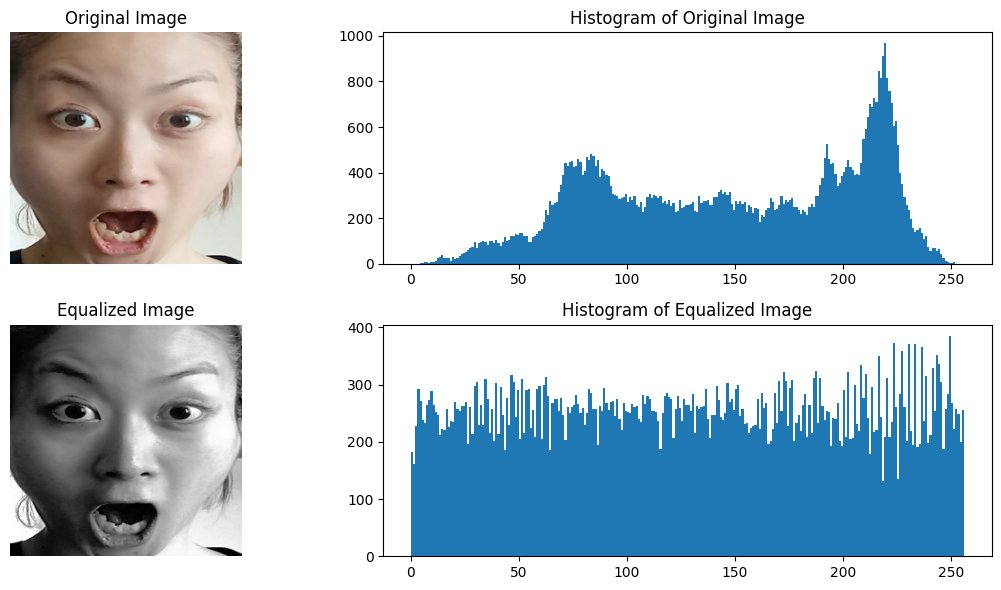

In [ ]:
#평활화 잘 되었는지 확인용.

import matplotlib.pyplot as plt

# 원본 이미지와 평활화된 이미지의 경로 설정
# 비교할 이미지 파일 이름 설정
image_name = 'f9b6f83a897ba44fd62aa9b81880f4472c1e88f457977edc3d4f3397534931f9_여_40_당황_숙박 및 거주공간_20210222220451-010-004.jpg'  # 원본 및 평활화된 이미지의 파일 이름

# 이미지 파일 경로
original_image_path = os.path.join(output_dir, image_name)
equalized_image_path = os.path.join(hist_dir, 'equalized_' + image_name)

# 이미지 읽기
original_image = cv2.imread(original_image_path)
equalized_image = cv2.imread(equalized_image_path)

if original_image is None:
    print(f"원본 이미지를 읽을 수 없습니다: {original_image_path}")
elif equalized_image is None:
    print(f"평활화된 이미지를 읽을 수 없습니다: {equalized_image_path}")
else:
    # 이미지를 흑백으로 변환 (히스토그램 비교를 위해)
    gray_original = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    gray_equalized = cv2.cvtColor(equalized_image, cv2.COLOR_BGR2GRAY)

    # 시각화
    plt.figure(figsize=(12, 6))

    # 원본 이미지와 히스토그램
    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.hist(gray_original.ravel(), 256, [0, 256])
    plt.title('Histogram of Original Image')

    # 평활화된 이미지와 히스토그램
    plt.subplot(2, 2, 3)
    plt.imshow(cv2.cvtColor(equalized_image, cv2.COLOR_BGR2RGB))
    plt.title('Equalized Image')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.hist(gray_equalized.ravel(), 256, [0, 256])
    plt.title('Histogram of Equalized Image')

    plt.tight_layout()
    plt.show()

In [ ]:
import os
import shutil
import random

# 원본 이미지가 들어 있는 폴더 경로
source_dir = "/content/drive/MyDrive/기계학습 팀 프로젝트/equalized_image"

# 데이터를 나눌 비율 설정
train_ratio = 0.7
validation_ratio = 0.2
test_ratio = 0.1

# 데이터를 저장할 폴더 경로 설정
data_dir = './drive/MyDrive/data'
train_dir = './drive/MyDrive/data/training'
validation_dir = './drive/MyDrive/data/validation'
test_dir = './drive/MyDrive/data/test'

# 폴더가 없으면 생성
if not os.path.exists(train_dir):
    print('생성완료')
    os.makedirs(train_dir)
if not os.path.exists(train_dir):
    print('생성완료')
    os.makedirs(train_dir)
if not os.path.exists(validation_dir):
    print('생성완료')
    os.makedirs(validation_dir)
if not os.path.exists(test_dir):
    print('생성완료')
    os.makedirs(test_dir)

# 이미지 파일 목록 가져오기
image_files = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]

# 이미지 파일 랜덤 셔플
random.shuffle(image_files)

# 데이터 나누기
num_images = len(image_files)
train_end = int(train_ratio * num_images)
validation_end = int((train_ratio + validation_ratio) * num_images)

train_files = image_files[:train_end]
validation_files = image_files[train_end:validation_end]
test_files = image_files[validation_end:]

# 파일을 각각의 폴더로 복사
for file in train_files:
    shutil.copy(os.path.join(source_dir, file), os.path.join(train_dir, file))

for file in validation_files:
    shutil.copy(os.path.join(source_dir, file), os.path.join(validation_dir, file))

for file in test_files:
    shutil.copy(os.path.join(source_dir, file), os.path.join(test_dir, file))

생성완료
생성완료
생성완료


In [ ]:
import os
import unicodedata

# 폴더 경로 설정
folder_path = './기계학습 팀 프로젝트/equalized_image'

# 변경할 단어 딕셔너리 설정
word_map = {
    '기쁨': 'happy',
    '당황': 'panic',
    '분노': 'angry',
    '상처': 'hurt'
}

# 폴더 내의 모든 파일명 가져오기
for file_name in os.listdir(folder_path):
    # 파일의 전체 경로 생성
    original_file_path = os.path.join(folder_path, file_name)

    file_name = unicodedata.normalize('NFC', file_name)

    # 파일인지 확인
    if os.path.isfile(original_file_path):
        new_file_name = file_name
        # 파일명에 각 단어가 포함되어 있는지 확인하고 변경
        for old_word, new_word in word_map.items():
            if old_word in file_name:
                new_file_name = new_file_name.replace(old_word, new_word)


        # 변경이 발생한 경우 파일명을 변경
        if new_file_name != file_name:
            new_file_path = os.path.join(folder_path, new_file_name)
            os.rename(original_file_path, new_file_path)
            print(f"File has been renamed from {file_name} to {new_file_name}")

print("All applicable files have been renamed.")

All applicable files have been renamed.
